# Sentinel-3 Product Dissemination Unit Comparison

    Version: 2.0
    Date:    17/09/2019
    Author:  Ben Loveday (Plymouth Marine Laboratory ) and Hayley Evers-King (EUMETSAT)
    Credit:  This code was developed for EUMETSAT under contracts for the Copernicus 
             programme.
    License: This code is offered as open source and free-to-use in the public domain, 
             with no warranty.

This code shows you the spatial extent of Sentinel-3 Level-1B and Level-2 NRT and NTC products from three different sensors (OLCI, SLSTR and SRAL). **To run this script, you will need to have your key for the harmonised data access API.** You can get your key from here; https://www.wekeo.eu/api-keys. If you click on the 'show hidden keys' button at the bottom of the page it will reveal a number of keys. The one you need is in the top grey box, and is on the following line:

-H "Authorization: Basic "**YOUR API KEY**"

Replace "YOUR API KEY" below with what you copy from "**YOUR API KEY**" (N.B. you need to keep the quotation marks.

In [1]:
%matplotlib inline

# libraries are imported here, and we can import any library with an alias that allows us easy access to them later.
import os, sys
import xarray as xr
import json
import numpy as np
import time
import glob
from zipfile import ZipFile
import matplotlib.pyplot as plt
from matplotlib import gridspec
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')

sys.path.append(os.path.dirname(os.getcwd()) + '/Hub_Tools/')
import harmonised_data_access_api_tools as hapi

Set up the harmonised data API so we can download data to the Jupyter hub workspace

In [2]:
api_key = "cmJ1UGJQVzZnT09HU2RUWDJhTGFkOGY4RjhnYTpGRmFCTTNoSXluVk1NdEk4b2dPc2ZjMHFOdlVh"
download_dir_path = "/home/jovyan/work/products"
JSON_query_dir = os.path.join(os.getcwd(),'JSON_templates')
verbose = False

In [3]:
dataset_ids = []
file_types = []
# OLCI REDUCED RESOLUTION L2 FILE
dataset_ids.append("EO:EUM:DAT:SENTINEL-3:OL_2_WRR___")
file_types.append('WRR')

# OLCI FULL RESOLUTION L2 FILE
dataset_ids.append("EO:EUM:DAT:SENTINEL-3:OL_2_WFR___")
file_types.append('WFR')

# SLSTR L1 FILE
dataset_ids.append("EO:EUM:DAT:SENTINEL-3:SL_1_RBT___")
file_types.append('RBT')

# SLSTR L2 FILE
dataset_ids.append("EO:EUM:DAT:SENTINEL-3:SL_2_WST___")
file_types.append('WST')

# SRAL L2 FILE
dataset_ids.append("EO:EUM:DAT:SENTINEL-3:SR_2_WAT___")
file_types.append('WAT')

In [4]:
# find query file
JSON_query_files = []
for dataset_id in dataset_ids:
    JSON_query_file = os.path.join(JSON_query_dir,dataset_id.replace(':','_')+".json")
    if not os.path.exists(JSON_query_file):
        print('Query file ' + JSON_query_file + ' does not exist')
    else:
        print('Found JSON query file for '+dataset_id)
    JSON_query_files.append(JSON_query_file)

Found JSON query file for EO:EUM:DAT:SENTINEL-3:OL_2_WRR___
Found JSON query file for EO:EUM:DAT:SENTINEL-3:OL_2_WFR___
Found JSON query file for EO:EUM:DAT:SENTINEL-3:SL_1_RBT___
Found JSON query file for EO:EUM:DAT:SENTINEL-3:SL_2_WST___
Found JSON query file for EO:EUM:DAT:SENTINEL-3:SR_2_WAT___


In [5]:
downloaded_files = []
for dataset_id,JSON_query_file in zip(dataset_ids, JSON_query_files):

    HAPI_dict = hapi.init(dataset_id, api_key, download_dir_path, verbose=verbose)
    HAPI_dict = hapi.get_access_token(HAPI_dict)
    HAPI_dict = hapi.accept_TandC(HAPI_dict)

    # load the query
    with open(JSON_query_file, 'r') as f:
        query = json.load(f)

    # launch job
    HAPI_dict = hapi.launch_query(HAPI_dict, query)

    # wait for jobs to complete
    hapi.check_job_status(HAPI_dict)

    # check results
    HAPI_dict = hapi.get_results_list(HAPI_dict)
    HAPI_dict = hapi.get_download_links(HAPI_dict)

    t0 = time.time()
    # download data
    HAPI_dict = hapi.download_data(HAPI_dict, skip_existing=True)

    # unzip file
    for filename in HAPI_dict['filenames']:
        downloaded_files.append(filename)
        if os.path.splitext(filename)[-1] == '.zip':
            print('Unzipping file')
            with ZipFile(filename, 'r') as zipObj:
                # Extract all the contents of zip file in current directory
                zipObj.extractall(os.path.dirname(filename))
                
    # flush benchmark timing to stdout print
    print(' ')
    print('--------------------------------')
    print('Elapsed time: ' +str(time.time() - t0))
    print('--------------------------------')
    print('\r')

Getting an access token. This token is valid for one hour only.
Success: Access token is 013249d3-fa25-3765-9cfa-08e2864944ce
Copernicus_General_License Terms and Conditions already accepted
Query successfully submitted. Job ID is 87dd74d2-908f-4b0c-8c05-453e3c26d383
The Job 87dd74d2-908f-4b0c-8c05-453e3c26d383 has not completed
The Job 87dd74d2-908f-4b0c-8c05-453e3c26d383 has completed
Total number of products/results :1
Skipping S3A_OL_2_WRR____20181026T082318_20181026T090734_20181027T135931_2656_037_178______MAR_O_NT_002.zip as it exists already
Unzipping file
 
--------------------------------
Elapsed time: 1.3756680488586426
--------------------------------

Getting an access token. This token is valid for one hour only.
Success: Access token is 013249d3-fa25-3765-9cfa-08e2864944ce
Copernicus_General_License Terms and Conditions already accepted
Query successfully submitted. Job ID is 068631ef-5641-44ae-96cb-1e09b6150f20
The Job 068631ef-5641-44ae-96cb-1e09b6150f20 has not complet

Sentinel-3 products from each sensor are delivered with different product dissemination units with different coverage. The files below will be used to make a plot that show all of the coverage options for each sensor and product, for a given timeliness.

Lets load in the data...

In [14]:
for downloaded_file, file_type in zip(downloaded_files, file_types):
    unzipped_file = downloaded_file.replace('.zip','.SEN3')
    if file_type == 'WRR':
        # OLCI REDUCED RESOLUTION --------------------------
        ds1 = xr.open_dataset(os.path.join(unzipped_file, 'geo_coordinates.nc'))
        OLCI_RR_LAT = ds1.latitude
        OLCI_RR_LON = ds1.longitude
        ds1.close()
    elif file_type == 'WFR':
        # OLCI FULL RESOLUTION --------------------------
        ds1 = xr.open_dataset(os.path.join(unzipped_file, 'geo_coordinates.nc'))
        OLCI_FR_LAT = ds1.latitude
        OLCI_FR_LON = ds1.longitude
        ds1.close()
    elif file_type == 'RBT':
        # SLSTR NADIR L1  --------------------------
        ds1 = xr.open_dataset(os.path.join(unzipped_file, 'geodetic_in.nc'))
        SLSTR_L1_LAT_N = ds1.latitude_in
        SLSTR_L1_LON_N = ds1.longitude_in
        ds1.close()
        # SLSTR OBLIQUE L1  --------------------------
        ds1 = xr.open_dataset(os.path.join(unzipped_file, 'geodetic_io.nc'))
        SLSTR_L1_LAT_O = ds1.latitude_io
        SLSTR_L1_LON_O = ds1.longitude_io
        ds1.close()
    elif file_type == 'WST':
        sub_file = glob.glob(os.path.join(unzipped_file, '*.nc'))[0]
        # SLSTR L2  --------------------------
        ds1 = xr.open_dataset(sub_file)
        SLSTR_L2_LAT = ds1.lat
        SLSTR_L2_LON = ds1.lon
        SLSTR_L2_ALG = np.squeeze(ds1.sst_algorithm_type)
        SLSTR_L2_LON_D = SLSTR_L2_LON.copy().values
        SLSTR_L2_LON_D[SLSTR_L2_ALG.values<3] = np.nan
        ds1.close()
    elif file_type == 'WAT':
        # SRAL L2  --------------------------
        ds1 = xr.open_dataset(os.path.join(unzipped_file, 'standard_measurement.nc'))
        SRAL_L2_LAT = ds1.lat_20_ku
        SRAL_L2_LON = ds1.lon_20_ku
        ds1.close()

SLSTR data is full orbit, which is hard to plot. We will manipulate it slightly near the date line to make our plots better.

In [15]:
# remove international date line edges to stop bad interpolation
SLSTR_L2_COL = np.ones(np.shape(SLSTR_L2_LON))
SLSTR_L2_COL_D = np.ones(np.shape(SLSTR_L2_LON_D))
SLSTR_L2_COL[SLSTR_L2_LON < -179.0] = np.nan
SLSTR_L2_COL[SLSTR_L2_LON > 179.0] = np.nan
SLSTR_L2_COL_D[SLSTR_L2_LON_D < -179.0] = np.nan
SLSTR_L2_COL_D[SLSTR_L2_LON_D > 179.0] = np.nan

Get the coastline data we need for our map plotting

In [16]:
land_resolution = '50m'
land_poly = cfeature.NaturalEarthFeature('physical', 'land', land_resolution,
                                        edgecolor='k',
                                        facecolor=cfeature.COLORS['land'])

Now we plot the data. This may take a little bit of time...

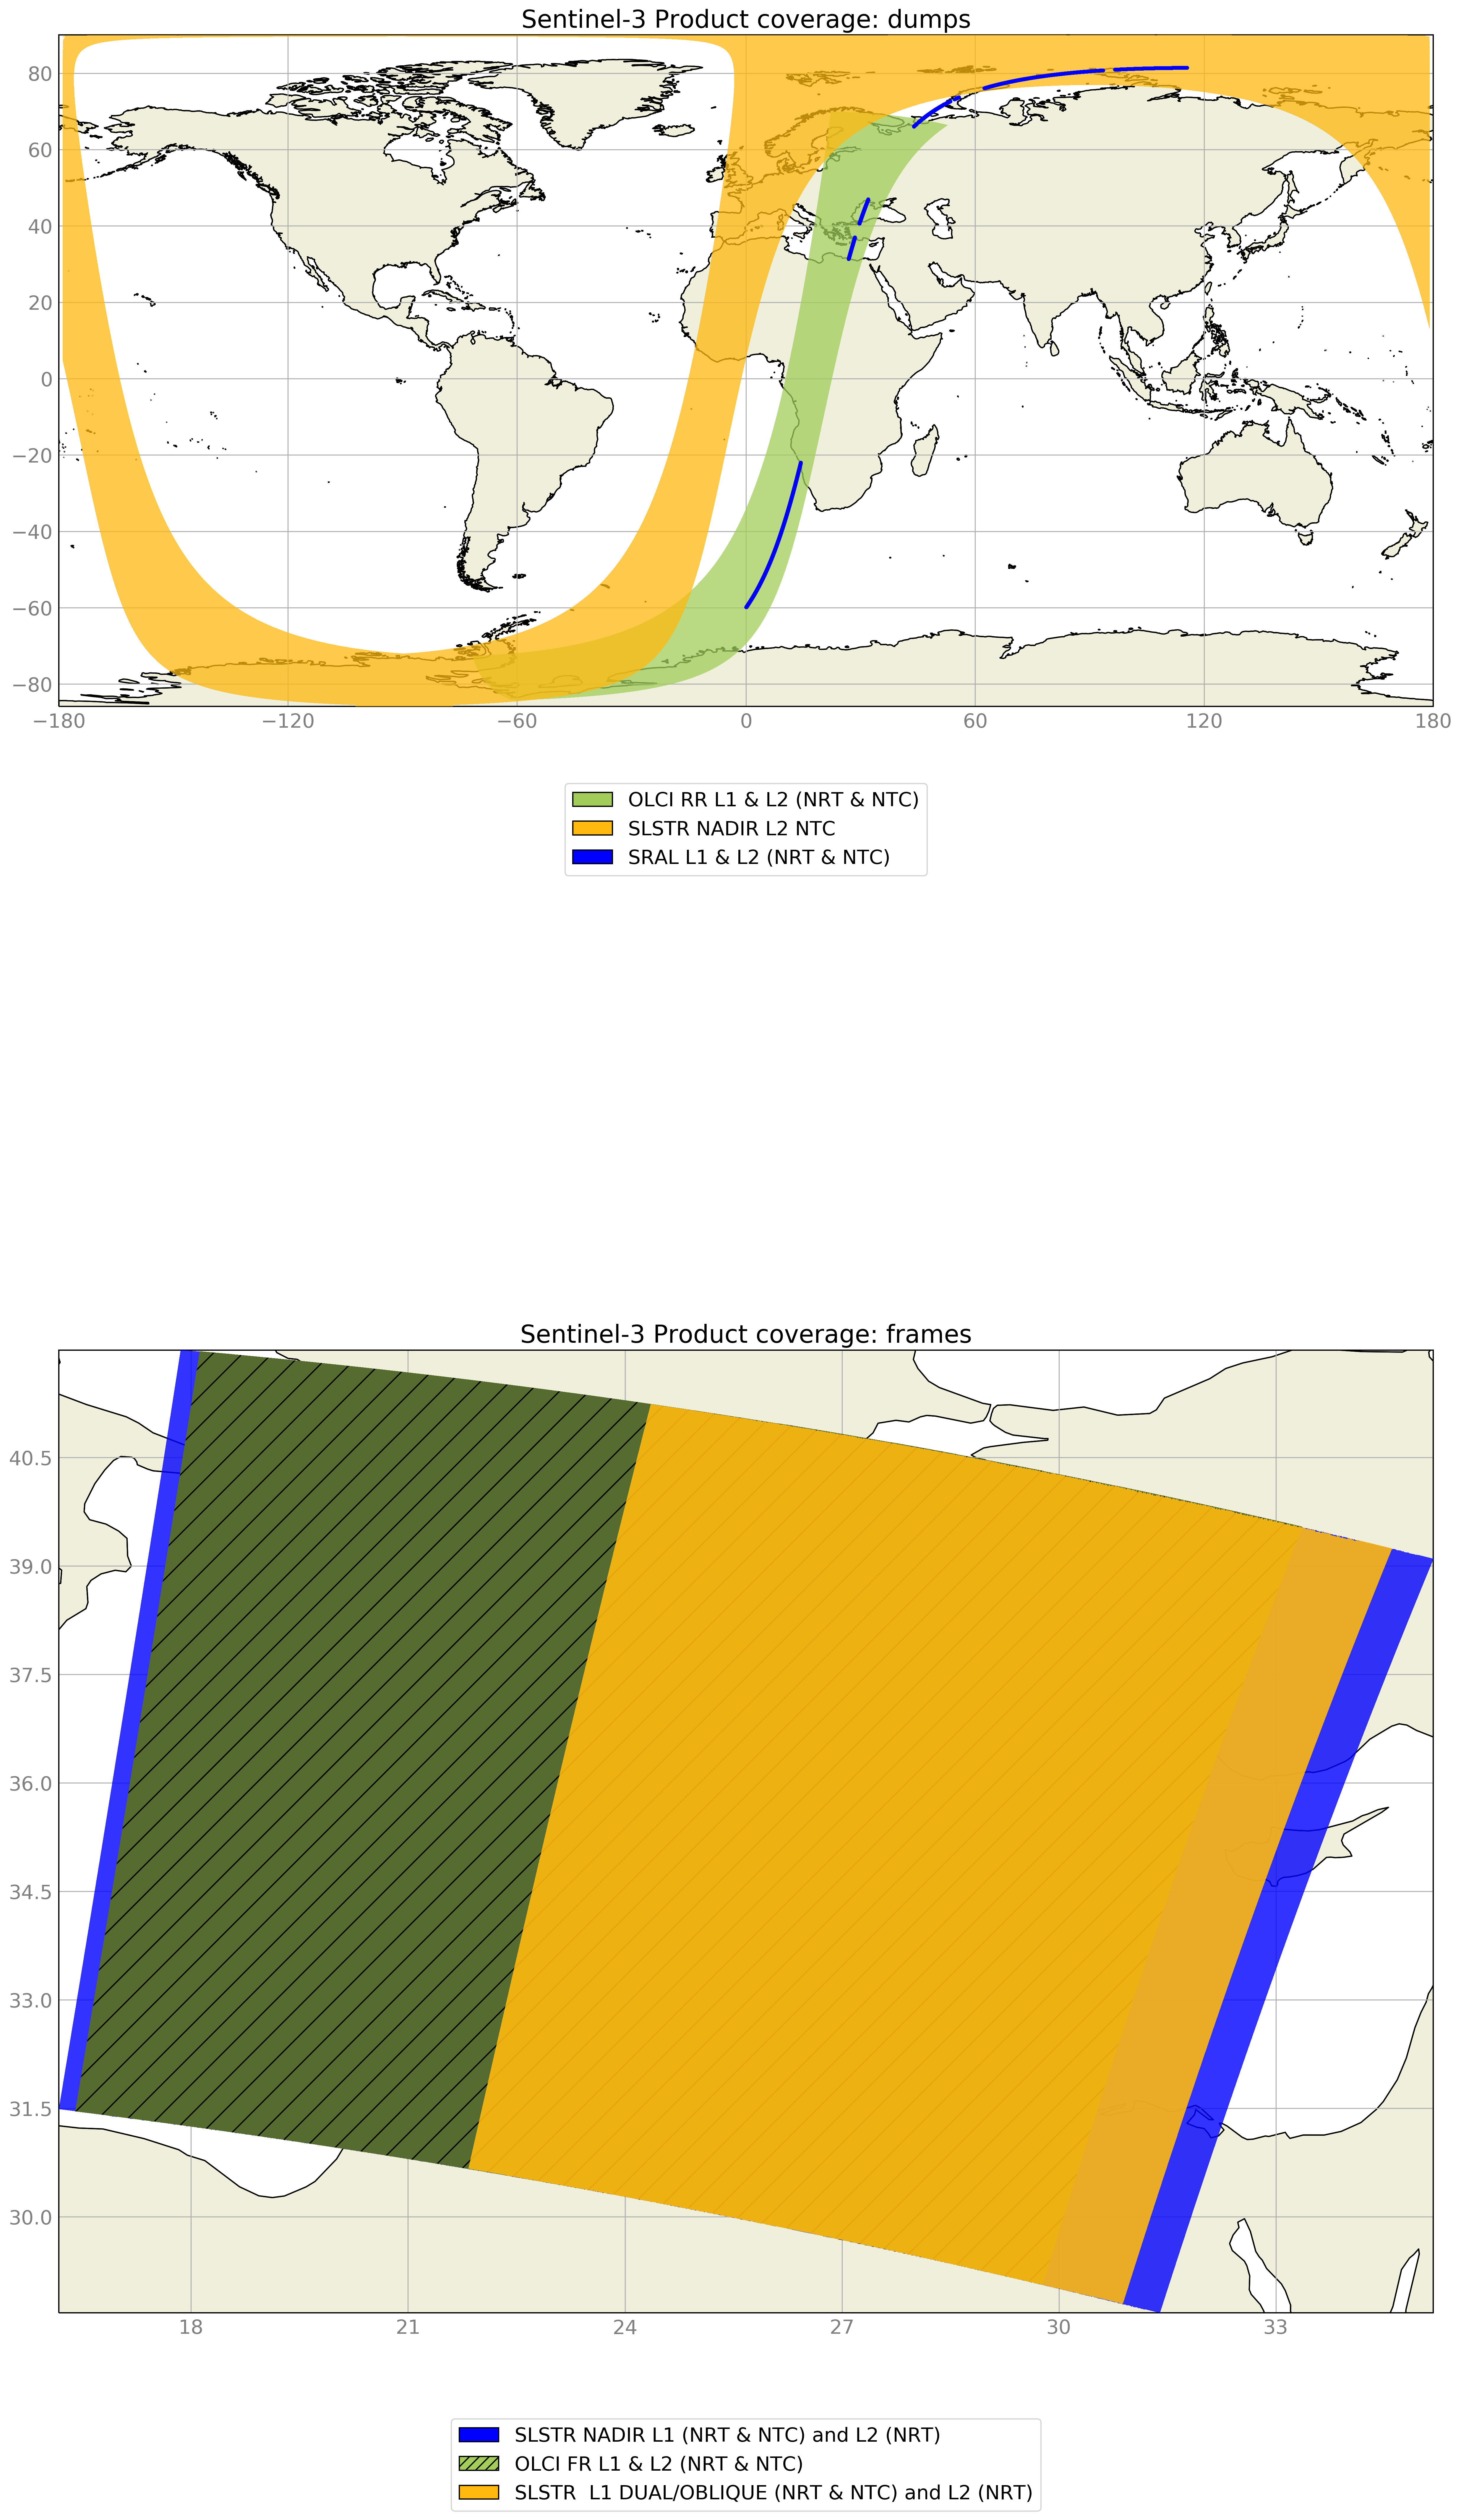

In [22]:
fig1 = plt.figure(figsize=(20, 40), dpi=300)

gs  = gridspec.GridSpec(2, 1)

#---
# plot dumps/stripes
m = plt.subplot(gs[0,0], projection = ccrs.PlateCarree(central_longitude=0.0))
levels = [0.0, 1.0]
f1 = m.contourf(OLCI_RR_LON, OLCI_RR_LAT, OLCI_RR_LAT*0.0+1.0, levels, colors=('#A2CD5A'), zorder=10, alpha=0.75)
f2 = m.plot(SRAL_L2_LON, SRAL_L2_LAT, marker='o', linewidth=0.0, color='b', zorder=14, markersize=2)
f3 = m.contourf(SLSTR_L2_LON, SLSTR_L2_LAT, SLSTR_L2_COL, levels, colors=('#FFB90F'), zorder=12, alpha=0.75)

m.coastlines(resolution=land_resolution, color='black', linewidth=1, zorder=1)
m.add_feature(land_poly, zorder=0)
g1 = m.gridlines(draw_labels = True)
g1.xlabels_top = False
g1.ylabels_right = False
g1.xlabel_style = {'size': 16, 'color': 'gray'}
g1.ylabel_style = {'size': 16, 'color': 'gray'}
plt.title('Sentinel-3 Product coverage: dumps', fontsize=20)

patch1 = mpatches.Patch(facecolor='#A2CD5A', edgecolor='k', label='OLCI RR L1 & L2 (NRT & NTC)')
patch2 = mpatches.Patch(facecolor='#FFB90F', edgecolor='k', label='SLSTR NADIR L2 NTC')
patch3 = mpatches.Patch(facecolor='b',       edgecolor='k', label='SRAL L1 & L2 (NRT & NTC)')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), handles=[patch1, patch2, patch3], fontsize=16)

# ---
# plot frames/granules
m = plt.subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=0.0))
levels = [0.0, 1.0]
f1 = m.contourf(OLCI_FR_LON, OLCI_FR_LAT, OLCI_FR_LAT*0.0+1.0, levels, colors=('#556B2F'), zorder=12,\
                alpha=1.0, hatches=['/'])
f2 = m.contourf(SLSTR_L1_LON_O, SLSTR_L1_LAT_O, SLSTR_L1_LAT_O*0.0+1.0, levels, colors=('#FFB90F'),\
                zorder=13, alpha=0.9)
f3 = m.contourf(SLSTR_L1_LON_N, SLSTR_L1_LAT_N, SLSTR_L1_LAT_N*0.0+1.0, levels, colors=('b'),\
                zorder=11, alpha=0.8)

m.coastlines(resolution=land_resolution, color='black', linewidth=1, zorder=1)
m.add_feature(land_poly, zorder=0)
g1 = m.gridlines(draw_labels = True)
g1.xlabels_top = False
g1.ylabels_right = False
g1.xlabel_style = {'size': 16, 'color': 'gray'}
g1.ylabel_style = {'size': 16, 'color': 'gray'}
plt.title('Sentinel-3 Product coverage: frames', fontsize=20)
patch1 = mpatches.Patch(facecolor='b',       edgecolor='k', label='SLSTR NADIR L1 (NRT & NTC) and L2 (NRT)')
patch2 = mpatches.Patch(facecolor='#A2CD5A', edgecolor='k', label='OLCI FR L1 & L2 (NRT & NTC)', hatch='///')
patch3 = mpatches.Patch(facecolor='#FFB90F', edgecolor='k', label='SLSTR  L1 DUAL/OBLIQUE (NRT & NTC) and L2 (NRT)')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), handles=[patch1, patch2, patch3], fontsize=16)
plt.show()